In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_csv("./data/x_train_preprocessing.csv")
test = pd.read_csv("./data/x_test_preprocessing.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
print(train.shape)
print(test.shape)

(7160, 299)
(1791, 298)


In [3]:
# setting hyperparameter
batch_size = 32
epochs = 40
lr = 0.01
train_ratio = 0.8

In [4]:
y_ = train.iloc[:,-1]

y_one_hot = np.zeros((len(y_), 6))  
y_one_hot[np.arange(len(y_)), y_] = 1

In [5]:
x_train = train.iloc[:,:-1]
x_test = test
y_train = y_one_hot


x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=1.0 - train_ratio,
                                                      stratify=y_train.argmax(axis=1))

print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: {}".format(len(x_train)))
print("validation set: {}".format(len(x_valid)))
print("testing set: {}".format(len(x_test)))

training set data dimension
(5728, 298)
(5728, 6)
-----------
training set: 5728
validation set: 1432
testing set: 1791


In [25]:
from tensorflow.keras.layers import Dense, Dropout
# import regularizer
from tensorflow.keras.regularizers import l1
# instantiate regularizer
reg = l1(0.0001)
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import LSTM

In [26]:
model = tf.keras.Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(298,)))
model.add(Dropout(0.2))
# model.add(Activation('relu'))
model.add(Dense(256, activation='relu', activity_regularizer=l1(0.00)))
model.add(Dense(128, activation='relu', activity_regularizer=reg))
model.add(Dense(64, activation='relu', activity_regularizer=l1(0.00)))
model.add(Dense(6, activation='sigmoid')) 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               76544     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 390       
Total params: 183,878
Trainable params: 183,878
Non-trainable params: 0
_________________________________________________________________
None

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [28]:
model_history = model.fit(x=x_train, y=y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=1 - train_ratio)

Train on 4582 samples, validate on 1146 samples
Epoch 1/40
4582/4582 [==============================] - 1s 217us/step - loss: 1.7451 - acc: 0.2433 - val_loss: 1.6187 - val_acc: 0.3298
Epoch 2/40
4582/4582 [==============================] - 1s 110us/step - loss: 1.5486 - acc: 0.3680 - val_loss: 1.4486 - val_acc: 0.4328
Epoch 3/40
4582/4582 [==============================] - 0s 108us/step - loss: 1.4328 - acc: 0.4186 - val_loss: 1.3629 - val_acc: 0.4424
Epoch 4/40
4582/4582 [==============================] - 0s 107us/step - loss: 1.3488 - acc: 0.4596 - val_loss: 1.3160 - val_acc: 0.4799
Epoch 5/40
4582/4582 [==============================] - 0s 107us/step - loss: 1.3154 - acc: 0.4867 - val_loss: 1.2923 - val_acc: 0.4930
Epoch 6/40
4582/4582 [==============================] - 0s 107us/step - loss: 1.2900 - acc: 0.4935 - val_loss: 1.2936 - val_acc: 0.5035
Epoch 7/40
4582/4582 [==============================] - 0s 107us/step - loss: 1.2595 - acc: 0.5085 - val_loss: 1.2658 - val_acc: 0.5288


In [29]:
train_loss = model_history.history['loss']
train_acc = model_history.history['acc']
valid_loss = model_history.history['val_loss']
valid_acc = model_history.history['val_acc']

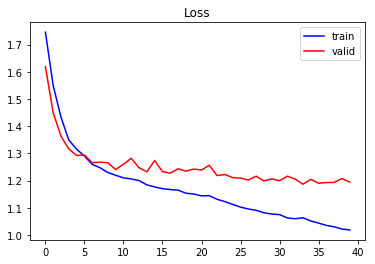

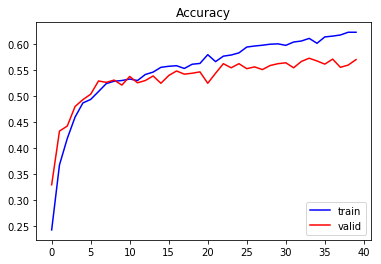

In [30]:
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [31]:
# save model
model.save('./keras_model/pokemon01.h5')

# load model
another_model = tf.keras.models.load_model('./keras_model/pokemon01.h5')

In [32]:
y_predict = another_model.predict_classes(x_test)

In [33]:
#make the submission data frame
test_id = pd.read_csv("./data/test.csv")
submission = {
    'ID': test_id.id,
    'class': y_predict
}
solution = pd.DataFrame(submission)
solution.head()

,ID,class
0,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
1,MTY0OTUyMTM2MDExMjg3MjczMjU=,1
2,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,4
3,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
4,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,5


In [34]:
solution.to_csv('submission_06.csv',index=False)